## Clasificadores

In [1]:
%matplotlib inline

In [3]:
from sentiment.tass import InterTASSReader, GeneralTASSReader
from sentiment.baselines import MostFrequent
from sentiment.classifier import SentimentClassifier
from sentiment.evaluator import Evaluator

def print_evaluation(model, y_cv, y_pred):
    # evaluate and print
    evaluator = Evaluator()
    evaluator.evaluate(y_cv, y_pred)
    evaluator.print_results()
    evaluator.print_confusion_matrix()

    # detailed confusion matrix, for result analysis
    cm_items = defaultdict(list)
    for i, (true, pred) in enumerate(zip(y_cv, y_pred)):
        cm_items[true, pred] += [i]

def learning_curve(model, X, y, X_cv, y_cv): 
    """
    Learning Curve of the model
    
    Returns ns, acc_curve, f1_curve
    """
    N = len(X)
    acc_curve = []
    evaluator = Evaluator()
    f1_curve = []
    ns = []
    for i in reversed(range(8)):
        n = int(N / 2**i)
        this_X = X[:n]
        this_y = y[:n]

        # train, test and evaluate
        model.fit(this_X, this_y)
        y_pred = model.predict(X_cv)
        evaluator.evaluate(y_cv, y_pred)

        # print this data point:
        acc = evaluator.accuracy()
        f1 = evaluator.macro_f1()
        
        acc_curve.append(acc)
        f1_curve.append(f1)
        ns.append(n)
    return ns, acc_curve, f1_curve
        
# load corpora
reader1 = InterTASSReader('../data/TASS/InterTASS/tw_faces4tassTrain1000rc.xml')
X1, y1 = list(reader1.X()), list(reader1.y())
reader2 = GeneralTASSReader('../data/TASS/GeneralTASS/general-tweets-train-tagged.xml', simple=True)
X2, y2 = list(reader2.X()), list(reader2.y())
X, y = X1 + X2, y1 + y2

reader_cv = InterTASSReader('../data/TASS/InterTASS/TASS2017_T1_development.xml')
X_cv, y_cv = list(reader_cv.X()), list(reader_cv.y())


## Sin tokenizador

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from nltk.tokenize import TweetTokenizer
from collections import defaultdict


clf_classes = [
    ('MaxEnt', LogisticRegression), 
    ('MNB', MultinomialNB), 
    ('SVM', LinearSVC)
]


def do_full_analysis(base_steps, full_name):
    sns.set_style("darkgrid")

    acc_curves = {}
    f1_curves = {}


    for name, clf_class in clf_classes:
        print("=" * 80)
        print(name)
        model = Pipeline([
            ('vect', CountVectorizer()),
            ('clf', clf_class()),
        ])

        model.fit(X, y)

        y_pred = model.predict(X_cv)
        print_evaluation(model, y_cv, y_pred)

        ns, acc_curve, f1_curve = learning_curve(model, X, y, X_cv, y_cv)
        acc_curves[name] = acc_curve
        f1_curves[name] = f1_curve

    ax1 = pd.DataFrame(acc_curves, index=ns).plot(title="{} Accuracy Learning Curves".format(full_name))
    plt.savefig("images/{}_acc.png".format(full_name))
    ax2 = pd.DataFrame(f1_curves, index=ns).plot(title="{} F1 Learning Curves".format(full_name))
    plt.savefig("images/{}_f1.png".format(full_name))
    

MaxEnt
Sentiment P:
  Precision: 52.89% (119/225)
  Recall: 76.28% (119/156)
  F1: 62.47%
Sentiment N:
  Precision: 60.65% (131/216)
  Recall: 59.82% (131/219)
  F1: 60.23%
Sentiment NEU:
  Precision: 15.79% (3/19)
  Recall: 4.35% (3/69)
  F1: 6.82%
Sentiment NONE:
  Precision: 28.26% (13/46)
  Recall: 20.97% (13/62)
  F1: 24.07%
Accuracy: 52.57% (266/506)
Macro-Precision: 39.40%
Macro-Recall: 40.35%
Macro-F1: 39.87%
	P	N	NEU	NONE
P	119	27	5	5	
N	60	131	7	21	
NEU	30	29	3	7	
NONE	16	29	4	13	
MNB
Sentiment P:
  Precision: 49.22% (127/258)
  Recall: 81.41% (127/156)
  F1: 61.35%
Sentiment N:
  Precision: 58.61% (143/244)
  Recall: 65.30% (143/219)
  F1: 61.77%
Sentiment NEU:
  Precision: 0.00% (0/1)
  Recall: 0.00% (0/69)
  F1: 0.00%
Sentiment NONE:
  Precision: 66.67% (2/3)
  Recall: 3.23% (2/62)
  F1: 6.15%
Accuracy: 53.75% (272/506)
Macro-Precision: 43.62%
Macro-Recall: 37.48%
Macro-F1: 40.32%
	P	N	NEU	NONE
P	127	28	1	0	
N	75	143	0	1	
NEU	35	34	0	0	
NONE	21	39	0	2	
SVM
Sentiment P:
  P

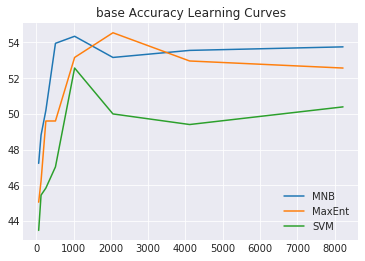

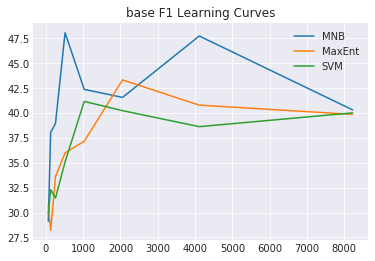

In [11]:
base_steps = [
    ('vect', CountVectorizer())
]

do_full_analysis(base_steps, "base")


## Con Tweet Tokenizer

In [5]:
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer()
model = Pipeline([
    ('vect', CountVectorizer(tokenizer=tknzr.tokenize)),
    ('clf', clf_class()),
])

model.fit(X, y)

y_pred = model.predict(X_cv)
        
print_evaluation(model, y_cv, y_pred)

Sentiment P:
  Precision: 57.80% (437/756)
  Recall: 68.07% (437/642)
  F1: 62.52%
Sentiment N:
  Precision: 62.81% (451/718)
  Recall: 58.80% (451/767)
  F1: 60.74%
Sentiment NEU:
  Precision: 16.53% (20/121)
  Recall: 9.26% (20/216)
  F1: 11.87%
Sentiment NONE:
  Precision: 25.33% (77/304)
  Recall: 28.10% (77/274)
  F1: 26.64%
Accuracy: 51.87% (985/1899)
Macro-Precision: 40.62%
Macro-Recall: 41.06%
Macro-F1: 40.84%
	P	N	NEU	NONE
P	437	101	30	74	
N	144	451	58	114	
NEU	73	84	20	39	
NONE	102	82	13	77	


## Tokenizador un poco mejor

In [6]:
tweets = X[10:50]

tweet_with_urls = [tw for tw in X if "http" in tw]

tweets = tweet_with_urls[:10]

In [7]:
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer()

for tw in tweets:
    print(tknzr.tokenize(tw))

['Nominada', 'por', '@learamartell', 'Aquí', 'van', 'nuestras', 'pelis', 'y', 'nuestros', 'taggeados', '.', 'https://t.co/hWqxW19Rjr']
['@ToniThrowdown', 'ahora', 'tengo', 'un', 'dilema', '.', 'Ayúdame', 'Toni', 'Y', 'en', '3DS', 'porque', 'me', 'salió', 'a', '25', 'euros', 'nuevo', 'https://t.co/2bSRMWnrZ5']
['Pocas', 'maneras', 'mejores', 'se', 'me', 'ocurren', 'para', 'empezar', 'una', 'semana', '...', 'https://t.co/P5wOXm5ffl']
['Hoy', 'microaventura', 'en', '#kayak', 'con', 'dos', 'expertos', 'kayakistas', 'Ría', 'de', 'Villaviciosa', '.', '@', 'El', 'Puntal', '…', 'https://t.co/y7j88bRmYK']
['Quiero', 'esta', 'figura', 'de', 'Madison', 'ojalá', 'que', 'la', 'próxima', 'en', 'salir', 'sea', 'Alicia', 'https://t.co/dTnJsrR8to']
['que', 'te', 'echo', 'de', 'menos', 'cosa', 'chicaa', '!', 'https://t.co/9QIk0GIVzO']
['Vale', ',', 'pero', 'creo', 'que', 'tendre', 'un', 'pequeño', 'problema', 'No', 'se', 'si', 'podre', 'tener', 'las', 'llaves', 'el', 'piso', 'para', 'las', 'fotos', 'htt

In [23]:
import re

tokenizer = TweetTokenizer(preserve_case=False, reduce_len=True, strip_handles=True)

def mytokenize(text, remove_hashtags=True):
    tokens = tokenizer.tokenize(text)
    
    tokens = [tk for tk in tokens if tk[0] != "#"]
    tokens = [tk for tk in tokens if not tk.startswith("http")]
    tokens = [re.sub(r'(.)\1\1+', r'\1\1', tk) for tk in tokens]
    return tokens


for tw in tweets:
    print(mytokenize(tw))

['nominada', 'por', 'aquí', 'van', 'nuestras', 'pelis', 'y', 'nuestros', 'taggeados', '.']
['ahora', 'tengo', 'un', 'dilema', '.', 'ayúdame', 'toni', 'y', 'en', '3ds', 'porque', 'me', 'salió', 'a', '25', 'euros', 'nuevo']
['pocas', 'maneras', 'mejores', 'se', 'me', 'ocurren', 'para', 'empezar', 'una', 'semana', '..']
['hoy', 'microaventura', 'en', 'con', 'dos', 'expertos', 'kayakistas', 'ría', 'de', 'villaviciosa', '.', '@', 'el', 'puntal', '…']
['quiero', 'esta', 'figura', 'de', 'madison', 'ojalá', 'que', 'la', 'próxima', 'en', 'salir', 'sea', 'alicia']
['que', 'te', 'echo', 'de', 'menos', 'cosa', 'chicaa', '!']
['vale', ',', 'pero', 'creo', 'que', 'tendre', 'un', 'pequeño', 'problema', 'no', 'se', 'si', 'podre', 'tener', 'las', 'llaves', 'el', 'piso', 'para', 'las', 'fotos']
['no', 'dobles', 'las', 'esquinas', '!', '😱', '😱', 'pon', 'post-its', '!', ',', 'se', 'queda', 'más', 'cuqui']
['mi', 'espalda', 'esta', 'bien', 'chicos', 'no', 'os', 'preocupeis', 'p', 'espero', 'que', 'el', 'ju

In [24]:
from nltk.tokenize import TweetTokenizer


model = Pipeline([
    ('vect', CountVectorizer(tokenizer=mytokenize)),
    ('clf', clf_class()),
])

model.fit(X, y)

y_pred = model.predict(X_cv)
        
print_evaluation(model, y_cv, y_pred)

Sentiment P:
  Precision: 58.45% (436/746)
  Recall: 67.91% (436/642)
  F1: 62.82%
Sentiment N:
  Precision: 61.55% (421/684)
  Recall: 54.89% (421/767)
  F1: 58.03%
Sentiment NEU:
  Precision: 15.56% (21/135)
  Recall: 9.72% (21/216)
  F1: 11.97%
Sentiment NONE:
  Precision: 25.45% (85/334)
  Recall: 31.02% (85/274)
  F1: 27.96%
Accuracy: 50.71% (963/1899)
Macro-Precision: 40.25%
Macro-Recall: 40.89%
Macro-F1: 40.57%
	P	N	NEU	NONE
P	436	100	27	79	
N	152	421	70	124	
NEU	68	81	21	46	
NONE	90	82	17	85	


Empeoró. Qué botonazo

## ¿Usándolo binario también?

In [27]:
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords

model = Pipeline([
    ('vect', CountVectorizer(tokenizer=TweetTokenizer().tokenize, binary=True)),
    ('clf', clf_class()),
])

model.fit(X, y)

y_pred = model.predict(X_cv)
        
print_evaluation(model, y_cv, y_pred)

Sentiment P:
  Precision: 56.90% (441/775)
  Recall: 68.69% (441/642)
  F1: 62.24%
Sentiment N:
  Precision: 62.61% (442/706)
  Recall: 57.63% (442/767)
  F1: 60.01%
Sentiment NEU:
  Precision: 15.50% (20/129)
  Recall: 9.26% (20/216)
  F1: 11.59%
Sentiment NONE:
  Precision: 27.68% (80/289)
  Recall: 29.20% (80/274)
  F1: 28.42%
Accuracy: 51.76% (983/1899)
Macro-Precision: 40.67%
Macro-Recall: 41.19%
Macro-F1: 40.93%
	P	N	NEU	NONE
P	441	99	31	71	
N	161	442	63	101	
NEU	74	85	20	37	
NONE	99	80	15	80	


In [28]:
from nltk.tokenize import TweetTokenizer


model = Pipeline([
    ('vect', CountVectorizer(tokenizer=mytokenize, binary=True)),
    ('clf', clf_class()),
])

model.fit(X, y)

y_pred = model.predict(X_cv)
        
print_evaluation(model, y_cv, y_pred)

Sentiment P:
  Precision: 58.09% (445/766)
  Recall: 69.31% (445/642)
  F1: 63.21%
Sentiment N:
  Precision: 63.28% (424/670)
  Recall: 55.28% (424/767)
  F1: 59.01%
Sentiment NEU:
  Precision: 12.68% (18/142)
  Recall: 8.33% (18/216)
  F1: 10.06%
Sentiment NONE:
  Precision: 27.73% (89/321)
  Recall: 32.48% (89/274)
  F1: 29.92%
Accuracy: 51.40% (976/1899)
Macro-Precision: 40.44%
Macro-Recall: 41.35%
Macro-F1: 40.89%
	P	N	NEU	NONE
P	445	93	30	74	
N	154	424	73	116	
NEU	76	80	18	42	
NONE	91	73	21	89	


# PCA

In [39]:
CountVectorizer(tokenizer=TweetTokenizer().tokenize).fit_transform(X, y)

<8227x24439 sparse matrix of type '<class 'numpy.int64'>'
	with 138496 stored elements in Compressed Sparse Row format>

In [40]:
from sklearn.decomposition import TruncatedSVD
from nltk.tokenize import TweetTokenizer


model = Pipeline([
    ('vect', CountVectorizer(tokenizer=TweetTokenizer().tokenize)),
    ('pca', TruncatedSVD(n_components=3000)),
    ('clf', clf_class()),
])

model.fit(X, y)

y_pred = model.predict(X_cv)
        
print_evaluation(model, y_cv, y_pred)

Sentiment P:
  Precision: 57.10% (426/746)
  Recall: 66.36% (426/642)
  F1: 61.38%
Sentiment N:
  Precision: 60.13% (457/760)
  Recall: 59.58% (457/767)
  F1: 59.86%
Sentiment NEU:
  Precision: 13.82% (17/123)
  Recall: 7.87% (17/216)
  F1: 10.03%
Sentiment NONE:
  Precision: 24.07% (65/270)
  Recall: 23.72% (65/274)
  F1: 23.90%
Accuracy: 50.82% (965/1899)
Macro-Precision: 38.78%
Macro-Recall: 39.38%
Macro-F1: 39.08%
	P	N	NEU	NONE
P	426	112	35	69	
N	154	457	55	101	
NEU	76	88	17	35	
NONE	90	103	16	65	
